# Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import math

In [2]:
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])

In [3]:
weird = []
index = 0
for item in data.iloc[:,0]:
    index+=1
    if item>=0 and item<5:
        print(str(item)+" the index is " + str(index))
        weird.append(index-1)
for item in weird:
    data.iloc[item,0] = np.nan
    print(data.iloc[item,0])
    
data.iloc[:,0] = data.iloc[:,0].interpolate(method='linear')
print(sum(np.isnan(x) for x in data.iloc[:,0]))

1.133 the index is 17249
0.0 the index is 17250
0.0 the index is 17251
0.0 the index is 17252
0.0 the index is 17253
0.0 the index is 17254
0.0 the index is 17255
0.0 the index is 28778
0.0 the index is 28779
nan
nan
nan
nan
nan
nan
nan
nan
nan
0


In [4]:
from scipy.stats import boxcox
outcome = data.iloc[:,0]
outcome, lmbda = boxcox(outcome)
print(lmbda)
print(np.max(outcome))

0.16848968115958027
6.424113843751646


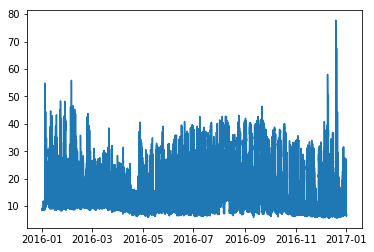

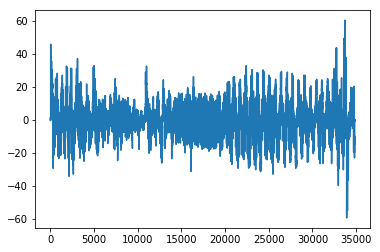

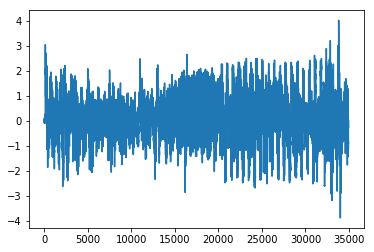

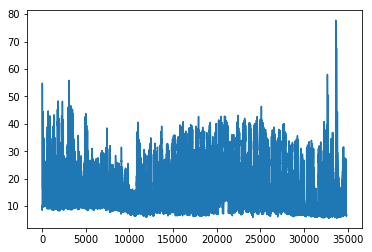

In [5]:
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

# define a dataset with a linear trend
pyplot.plot(data.iloc[:,0])
pyplot.show()
# difference the dataset
diff1 = difference(data.iloc[:,0],290)
pyplot.plot(diff1)
pyplot.show()

diff2 = difference(outcome,190)
pyplot.plot(diff2)
pyplot.show()

# invert the difference
inverted = [inverse_difference(data.iloc[:,0][i], diff1[i]) for i in range(len(diff1))]

pyplot.plot(inverted)
pyplot.show()

In [6]:
# These are the univariate datasets of USAGE_KWH with various transformations

orig_data = data.iloc[:,0] #original data (Nontransformed)
orig_diff = pd.DataFrame(diff1) #differenced data
box_data = pd.DataFrame(outcome) #boxcox transformed data
box_diff = pd.DataFrame(diff2) #differenced data from boxcox transformed data

In [7]:
from math import log
from math import exp
def invert_diff(predictions,past_value):
    new_preds=[]
    for item in range(len(predictions)):
        temp = predictions[item] + past_value[item]
        new_preds.append(temp)
    return new_preds

def invert_boxcox(value, lam):
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)


# These are the values to be input in the invert_diff as the "past_value" parameter
orig_diff1_96 = data.iloc[-96-290:-290,0] # for inverting the original dataset that had differencing applied (when the test set is 96)

box_diff1_96 = outcome[-96-190:-190]# for inverting the boxcox dataset that had differencing applied (when the test set is 96)

orig_diff1_960 = data.iloc[-960-290:-290,0]

# Univariate Models

## Baseline (Persistence Model)

predicted=7.220000, expected=7.046000
predicted=7.181000, expected=7.114000
predicted=7.469000, expected=7.181000
predicted=7.978000, expected=7.277000
predicted=7.834000, expected=7.325000
predicted=7.949000, expected=7.114000
predicted=7.968000, expected=7.286000
predicted=7.805000, expected=7.219000
predicted=7.373000, expected=7.738000
predicted=7.181000, expected=7.296000
predicted=6.528000, expected=7.190000
predicted=7.066000, expected=7.315000
predicted=7.191000, expected=7.142000
predicted=7.056000, expected=7.258000
predicted=7.604000, expected=7.200000
predicted=7.296000, expected=7.219000
predicted=7.258000, expected=7.018000
predicted=7.200000, expected=7.296000
predicted=6.980000, expected=10.128000
predicted=6.711000, expected=17.414000
predicted=7.028000, expected=26.035000
predicted=7.335000, expected=27.274000
predicted=13.796000, expected=26.851000
predicted=14.247000, expected=25.901000
predicted=12.173000, expected=25.075000
predicted=11.741000, expected=23.654000


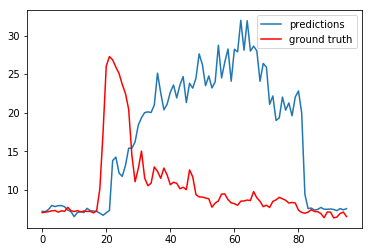

In [18]:
from pandas import Series
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

# in front of the ".values" code, input the name of the dataset version to analyze (namely: orig_data, orig_diff,box_data,box_diff)
values = DataFrame(orig_diff.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
X = dataframe.values
train, test = X[1:len(X)-96], X[len(X)-96:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

predictions = list()
for x in test_X:
    yhat = train_y[-1]
    predictions.append(yhat)

# Comment out the following 4 lines of code depending on what is appropriate to invert    
first1= invert_diff(predictions,orig_diff1_96) # differences the predictions (either use orig_diff1_96 or box_diff1_96)
#second1 =[invert_boxcox(x, lmbda) for x in first1] # only use this when boxcox transformation was applied; otherwise comment out

first2 = invert_diff(test_y,orig_diff1_96) # differences the ground truth values (either use orig_diff1_96 or box_diff1_96)
#second2 = [invert_boxcox(x, lmbda) for x in first2]  # only use this when boxcox transformation was applied; otherwise comment out

for i in range(len(first2)):
    print('predicted=%f, expected=%f' % (first1[i], first2[i]))
test_score = mean_squared_error(first2,first1) #if boxcox transformation was used, replace first2, first1 with second2, second1 respectively

print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
#if boxcox transformation was used, replace first2, first1 with second2, second1 respectively
pyplot.plot(first1,label='predictions')
pyplot.plot(first2, color='red',label='ground truth')
pyplot.legend()
pyplot.show()

## AR Model

Lag: 51
Coefficients: [ 2.58311985e-03  1.11056110e+00 -3.42619490e-01  2.07253369e-01
 -6.13679178e-02  2.59668866e-02  1.05891413e-02  7.31691764e-03
  1.60238858e-02 -1.53372557e-02  2.76827340e-02 -6.39543448e-03
 -9.28206327e-03  3.41844214e-03  1.10240392e-02  7.96154240e-03
 -2.18654580e-02 -3.26133190e-02  4.27864890e-03  5.10089099e-03
  9.64920251e-03  2.48674519e-02  6.76569289e-03 -3.04080916e-02
  3.10748149e-03 -4.31570115e-03  1.45771127e-02 -9.97985521e-03
  4.47069213e-03 -1.18046725e-02  1.89113077e-02  4.47590078e-03
 -2.31620797e-02 -1.99790296e-02  1.28896586e-02  4.25343312e-03
  5.50942101e-03  1.97322901e-02  9.37256641e-04  7.95155864e-04
 -1.23943160e-02  1.48304341e-03 -1.18842219e-03  4.11966033e-03
 -1.96232047e-02  2.06927225e-02 -3.21424044e-04 -1.45366915e-02
 -3.48926221e-02  3.87167904e-02 -3.17824303e-03  8.55899411e-03]
predicted=6.297580, expected=7.190000
predicted=6.491105, expected=6.662000
predicted=6.814533, expected=6.490000
predicted=6.995635

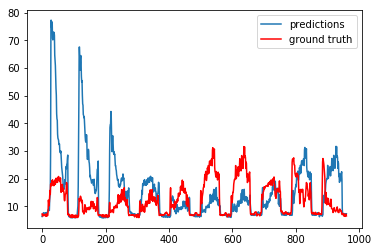

In [24]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

# in front of the ".values" code, input the name of the dataset version to analyze (namely: orig_data, orig_diff,box_data,box_diff)
X = orig_diff.values
train, test = X[1:len(X)-960], X[len(X)-960:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Comment out the following 4 lines of code depending on what is appropriate to invert    
first1= invert_diff(predictions,orig_diff1_960) # differences the predictions (either use orig_diff1_96 or box_diff1_96)
#second1 =[invert_boxcox(x, lmbda) for x in predictions] # only use this when boxcox transformation was applied; otherwise comment out

first2 = invert_diff(test,orig_diff1_960) # differences the ground truth values (either use orig_diff1_96 or box_diff1_96)
#second2 = [invert_boxcox(x, lmbda) for x in test]  # only use this when boxcox transformation was applied; otherwise comment out

for i in range(len(first2)):
    print('predicted=%f, expected=%f' % (first1[i], first2[i]))
test_score = mean_squared_error(first2,first1) #if boxcox transformation was used, replace first2, first1 with second2, second1 respectively

print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
#if boxcox transformation was used, replace first2, first1 with second2, second1 respectively
pyplot.plot(first1,label='predictions')
pyplot.plot(first2, color='red',label='ground truth')
pyplot.legend()
pyplot.show()

Lag: 52
Coefficients: [ 2.13557411e-04  1.11304213e+00 -3.40768705e-01  2.04393180e-01
 -5.97828627e-02  2.46870140e-02  1.22860956e-02  4.89805552e-03
  1.48765083e-02 -1.26210102e-02  2.40532720e-02 -6.08306712e-03
 -8.98709702e-03  3.07281844e-03  1.09894193e-02  8.11730447e-03
 -2.34135285e-02 -3.09926455e-02  4.12195936e-03  4.83374385e-03
  1.07450675e-02  2.45389177e-02  4.32001538e-03 -2.76913861e-02
  3.82919017e-03 -5.43132539e-03  1.40814977e-02 -9.18362679e-03
  3.74271172e-03 -1.07692031e-02  1.88519573e-02  4.05090681e-03
 -2.48730423e-02 -1.81099448e-02  1.09509726e-02  4.19751633e-03
  7.49057701e-03  2.02757921e-02  5.93799833e-04 -8.04181043e-04
 -9.61845081e-03  2.12943879e-04  2.11526912e-03  9.41842427e-04
 -1.72004581e-02  1.67905611e-02  1.52407787e-03 -1.50180668e-02
 -3.30009292e-02  3.30664290e-02  3.64614466e-03 -1.44726726e-02
  2.04469097e-02]
predicted=7.057661, expected=7.046000
predicted=7.583727, expected=7.114000
predicted=7.872980, expected=7.181000
p

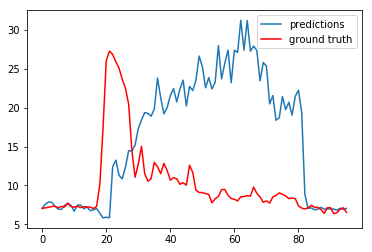

In [25]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

# in front of the ".values" code, input the name of the dataset version to analyze (namely: orig_data, orig_diff,box_data,box_diff)
X = orig_diff.values
train, test = X[1:len(X)-96], X[len(X)-96:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Comment out the following 4 lines of code depending on what is appropriate to invert    
first1= invert_diff(predictions,orig_diff1_96) # differences the predictions (either use orig_diff1_96 or box_diff1_96)
#second1 =[invert_boxcox(x, lmbda) for x in predictions] # only use this when boxcox transformation was applied; otherwise comment out

first2 = invert_diff(test,orig_diff1_96) # differences the ground truth values (either use orig_diff1_96 or box_diff1_96)
#second2 = [invert_boxcox(x, lmbda) for x in test]  # only use this when boxcox transformation was applied; otherwise comment out

for i in range(len(first2)):
    print('predicted=%f, expected=%f' % (first1[i], first2[i]))
test_score = mean_squared_error(first2,first1) #if boxcox transformation was used, replace first2, first1 with second2, second1 respectively

print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
#if boxcox transformation was used, replace first2, first1 with second2, second1 respectively
pyplot.plot(first1,label='predictions')
pyplot.plot(first2, color='red',label='ground truth')
pyplot.legend()
pyplot.show()

# MA Model

Lag: 0
Coefficients: [0.04713952 0.87153322]
predicted=6.592962, expected=7.046000
predicted=6.834140, expected=7.114000
predicted=7.122140, expected=7.181000
predicted=7.631140, expected=7.277000
predicted=7.487140, expected=7.325000
predicted=7.602140, expected=7.114000
predicted=7.621140, expected=7.286000
predicted=7.458140, expected=7.219000
predicted=7.026140, expected=7.738000
predicted=6.834140, expected=7.296000
predicted=6.181140, expected=7.190000
predicted=6.719140, expected=7.315000
predicted=6.844140, expected=7.142000
predicted=6.709140, expected=7.258000
predicted=7.257140, expected=7.200000
predicted=6.949140, expected=7.219000
predicted=6.911140, expected=7.018000
predicted=6.853140, expected=7.296000
predicted=6.633140, expected=10.128000
predicted=6.364140, expected=17.414000
predicted=6.681140, expected=26.035000
predicted=6.988140, expected=27.274000
predicted=13.449140, expected=26.851000
predicted=13.900140, expected=25.901000
predicted=11.826140, expected=25.07

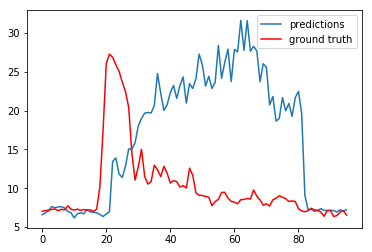

In [26]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from pandas import Series
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

# in front of the ".values" code, input the name of the dataset version to analyze (namely: orig_data, orig_diff,box_data,box_diff)
X = orig_diff.values
train, test = X[1:len(X)-96], X[len(X)-96:]

model = ARMA(train, order=(0, 1))
model_fit = model.fit(disp=False)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Comment out the following 4 lines of code depending on what is appropriate to invert    
first1= invert_diff(predictions,orig_diff1_96) # differences the predictions (either use orig_diff1_96 or box_diff1_96)
#second1 =[invert_boxcox(x, lmbda) for x in first1] # only use this when boxcox transformation was applied; otherwise comment out

first2 = invert_diff(test,orig_diff1_96) # differences the ground truth values (either use orig_diff1_96 or box_diff1_96)
#second2 = [invert_boxcox(x, lmbda) for x in first2]  # only use this when boxcox transformation was applied; otherwise comment out

for i in range(len(second2)):
    print('predicted=%f, expected=%f' % (first1[i], first2[i]))
test_score = mean_squared_error(first2,first1) #if boxcox transformation was used, replace first2, first1 with second2, second1 respectively

print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
#if boxcox transformation was used, replace first2, first1 with second2, second1 respectively
pyplot.plot(first1,label='predictions')
pyplot.plot(first2, color='red',label='ground truth')
pyplot.legend()
pyplot.show()

# ARMA Model

Lag: 2
Coefficients: [0.04716196 0.55686669 0.37382194 0.5898551 ]
predicted=6.979286, expected=7.046000
predicted=7.022914, expected=7.114000
predicted=7.266943, expected=7.181000
predicted=7.782346, expected=7.277000
predicted=7.625474, expected=7.325000
predicted=7.735699, expected=7.114000
predicted=7.747228, expected=7.286000
predicted=7.578283, expected=7.219000
predicted=7.140180, expected=7.738000
predicted=6.942559, expected=7.296000
predicted=6.284147, expected=7.190000
predicted=6.817032, expected=7.315000
predicted=6.937160, expected=7.142000
predicted=6.797536, expected=7.258000
predicted=7.341139, expected=7.200000
predicted=7.028962, expected=7.219000
predicted=6.986992, expected=7.018000
predicted=6.925220, expected=7.296000
predicted=6.701636, expected=10.128000
predicted=6.429230, expected=17.414000
predicted=6.742993, expected=26.035000
predicted=7.046918, expected=27.274000
predicted=13.504995, expected=26.851000
predicted=13.953218, expected=25.901000
predicted=11.

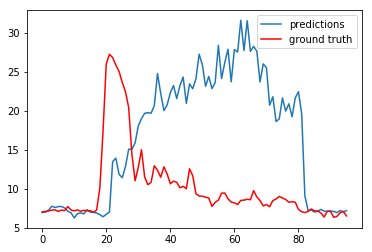

In [27]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from pandas import Series
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

# in front of the ".values" code, input the name of the dataset version to analyze (namely: orig_data, orig_diff,box_data,box_diff)
X = orig_diff.values
train, test = X[1:len(X)-96], X[len(X)-96:]

model = ARMA(train, order=(2, 1))
model_fit = model.fit(disp=False)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Comment out the following 4 lines of code depending on what is appropriate to invert    
first1= invert_diff(predictions,orig_diff1_96) # differences the predictions (either use orig_diff1_96 or box_diff1_96)
#second1 =[invert_boxcox(x, lmbda) for x in first1] # only use this when boxcox transformation was applied; otherwise comment out

first2 = invert_diff(test,orig_diff1_96) # differences the ground truth values (either use orig_diff1_96 or box_diff1_96)
#second2 = [invert_boxcox(x, lmbda) for x in first2]  # only use this when boxcox transformation was applied; otherwise comment out

for i in range(len(first2)):
    print('predicted=%f, expected=%f' % (first1[i], first2[i]))
test_score = mean_squared_error(first2,first1) #if boxcox transformation was used, replace first2, first1 with second2, second1 respectively

print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
#if boxcox transformation was used, replace first2, first1 with second2, second1 respectively
pyplot.plot(first1,label='predictions')
pyplot.plot(first2, color='red',label='ground truth')
pyplot.legend()
pyplot.show()

# SARIMA Model

predicted=7.229427, expected=7.046000
predicted=7.454926, expected=7.114000
predicted=7.798030, expected=7.181000
predicted=8.184592, expected=7.277000
predicted=8.140766, expected=7.325000
predicted=8.147586, expected=7.114000
predicted=7.961130, expected=7.286000
predicted=8.020768, expected=7.219000
predicted=7.190883, expected=7.738000
predicted=6.716849, expected=7.296000
predicted=6.460581, expected=7.190000
predicted=6.944791, expected=7.315000
predicted=7.203785, expected=7.142000
predicted=7.333257, expected=7.258000
predicted=7.936076, expected=7.200000
predicted=7.505538, expected=7.219000
predicted=7.567898, expected=7.018000
predicted=7.401753, expected=7.296000
predicted=6.976510, expected=10.128000
predicted=6.930174, expected=17.414000
predicted=6.849573, expected=26.035000
predicted=6.874640, expected=27.274000
predicted=13.732186, expected=26.851000
predicted=14.129361, expected=25.901000
predicted=12.189142, expected=25.075000
predicted=12.021588, expected=23.654000


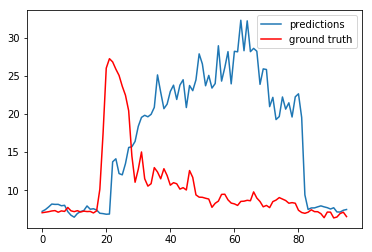

In [28]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import Series
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

# in front of the ".values" code, input the name of the dataset version to analyze (namely: orig_data, orig_diff,box_data,box_diff)
X = orig_diff.values
train, test = X[1:len(X)-96], X[len(X)-96:]

model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(1, 1, 2, 6))
model_fit = model.fit(disp=False)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Comment out the following 4 lines of code depending on what is appropriate to invert    
first1= invert_diff(predictions,orig_diff1_96) # differences the predictions (either use orig_diff1_96 or box_diff1_96)
#second1 =[invert_boxcox(x, lmbda) for x in first1] # only use this when boxcox transformation was applied; otherwise comment out

first2 = invert_diff(test,orig_diff1_96) # differences the ground truth values (either use orig_diff1_96 or box_diff1_96)
#second2 = [invert_boxcox(x, lmbda) for x in first2]  # only use this when boxcox transformation was applied; otherwise comment out

for i in range(len(first1)):
    print('predicted=%f, expected=%f' % (first1[i], first2[i]))
test_score = mean_squared_error(first2,first1) #if boxcox transformation was used, replace first2, first1 with second2, second1 respectively

print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
#if boxcox transformation was used, replace first2, first1 with second2, second1 respectively
pyplot.plot(first1,label='predictions')
pyplot.plot(first2, color='red',label='ground truth')
pyplot.legend()
pyplot.show()

# Multivariate Models

## VAR Model (Predicted Values Approaching Infinity)

C:\Derek\AIProject\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Derek\AIProject\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:52: RuntimeWarning: invalid value encountered in reduce
  return getattr(obj, method)(*args, **kwds)
C:\Derek\AIProject\Anaconda\lib\site-packages\sklearn\metrics\regression.py:239: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


Test MSE: inf


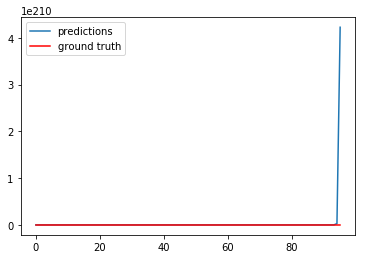

In [14]:
from pandas import Series
from math import sqrt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

train = data.iloc[0:data.shape[0]-96]
test=data.iloc[data.shape[0]-96:]
test_usage = test.iloc[:,0]

model = VAR(endog=train)
model_fit = model.fit()

prediction = model_fit.forecast(model_fit.y, steps=len(test))
predictions = prediction[:,0]

'''# Comment out the following 4 lines of code depending on what is appropriate to invert    
first1= invert_diff(predictions,box_diff1_96) # differences the predictions (either use orig_diff1_96 or box_diff1_96)
second1 =[invert_boxcox(x, lmbda) for x in first1] # only use this when boxcox transformation was applied; otherwise comment out

first2 = invert_diff(test,box_diff1_96) # differences the ground truth values (either use orig_diff1_96 or box_diff1_96)
second2 = [invert_boxcox(x, lmbda) for x in first2]  # only use this when boxcox transformation was applied; otherwise comment out
'''

test_score = mean_squared_error(test_usage.values,predictions) #if boxcox transformation was used, replace first2, first1 with second2, second1 respectively

print('Test MSE: %.3f' % test_score)

pyplot.plot(predictions,label='predictions')
pyplot.plot(test_usage.values, color='red',label='ground truth')
pyplot.legend()
pyplot.show()

In [ ]:
# VARMA example
from statsmodels.tsa.statespace.varmax import VARMAX
from pandas import Series
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

train = data.iloc[0:data.shape[0]-96]
test=data.iloc[data.shape[0]-96:]
test_usage = test.iloc[:,0]

# fit model
model = VARMAX(train, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
prediction = model_fit.forecast()
predictions = prediction.iloc[:,0]

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test_usage[i]))

C:\Derek\AIProject\Anaconda\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Derek\AIProject\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


In [16]:
# SES example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# in front of the ".values" code, input the name of the dataset version to analyze (namely: orig_data, orig_diff,box_data,box_diff)
train = data.iloc[0:data.shape[0]-96,0]
test=data.iloc[data.shape[0]-96:,0]

model = SimpleExpSmoothing(train)
model_fit = model.fit()
# make prediction
predictions = model_fit.predict(len(train), len(train)+len(test)-1)

error1 = mean_squared_error(predictions, test)

print('Test MSE: %.3f' % error1)

C:\Derek\AIProject\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


Test MSE: 32.070


In [17]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = data.iloc[0:data.shape[0]-96,0]
test=data.iloc[data.shape[0]-96:,0]

#shows = data.iloc[data.shape[0]-1096:,0]

model = ExponentialSmoothing(train)
model_fit = model.fit()
# make prediction
predictions = model_fit.predict(len(train), len(train)+len(test)-1)

error1 = mean_squared_error(predictions, test)

print('Test MSE: %.3f' % error1)

C:\Derek\AIProject\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


Test MSE: 32.070
